Emulating the [DFG benchmark 2D-1, Re=20](https://wwwold.mathematik.tu-dortmund.de/~featflow/en/benchmarks/cfdbenchmarking/flow/dfg_benchmark1_re20.html)
laminar flow (no time dependency) using a single PINN (no domain decomposition)

This notebook contains code for initializing the XPINN, explaining the problem specifications from [DFG benchmark 2D-1](https://wwwold.mathematik.tu-dortmund.de/~featflow/en/benchmarks/cfdbenchmarking/flow/dfg_benchmark1_re20.html), setting up the network architecture, defining the pde residual functions, specifying the boundary conditions and training the network

#### Initalizing the XPINN

The structure of our train .json data tells XPINN that there is no domain decomposition

In [1]:
from xpinn import XPINN
import jax.numpy as np
from utils import data_path

data_path = data_path / "NavierStokes"

file_train = data_path / "single_pinn_train.json"
file_test = data_path / "test.json"
activation = np.tanh
xpinn = XPINN(file_train, activation)

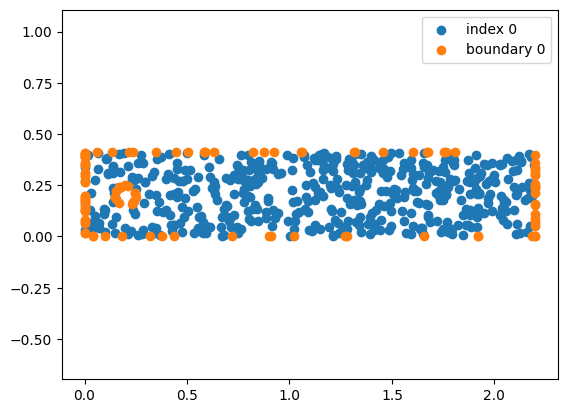

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.axis("equal"
)
for i, pinn in enumerate(xpinn.PINNs):
    checkout = pinn.interior
    plt.scatter(checkout[:, 0], checkout[:, 1], label=f"index {i}")
    plt.scatter(pinn.boundary[:, 0], pinn.boundary[:, 1], label=f"boundary {i}")

for interface in xpinn.Interfaces:
    a, b = interface.indices
    p = interface.points
    plt.scatter(p[:, 0], p[:, 1], label=f"interface {a}-{b}")

plt.legend()

# Problem specifications

We attempt to replicate the laminar cylinder-wake navier stokes benchmark from [DFG benchmark 2D-1](https://wwwold.mathematik.tu-dortmund.de/~featflow/en/benchmarks/cfdbenchmarking/flow/dfg_benchmark1_re20.html). The incompressible liquid flows from left to right, hitting the cylinder on its way. In the dortmund article they have used U to denote vector for the fluid flow velocity, in this code however we found it convenient to isolate the x- and y-flow which is denoted respectively as u and v throughout

### The interior PDE constraints
In the DFG benchmark 2D-1, the PDE conditions are given by the Navier-Stokes equations:

$$-\nu \nabla^2 \mathbf{u} + (\mathbf{u} \cdot \nabla)\mathbf{u} + \nabla p = \mathbf{0}, \hspace{3mm} \nabla \cdot \mathbf{u} = 0$$

$\nu = 0.001$.
In our notation, which isolates the x- and y-flow as $u$ and $v$, the PDE expressions for the second-order spatial derivatives can be written as:

$$-\nu (u_{xx} + u_{yy}) + u u_x + v u_y + p_x = 0,$$

$$-\nu (v_{xx} + v_{yy}) + u v_x + v v_y + p_y = 0$$

Our zero divergence from incompressibility:

$$ u_x + v_y = 0$$

Let's denote our PDE in the x and y direction as f and g


$$ f = -\nu (u_{xx} + u_{yy}) + u u_x + v u_y + p_x = 0,$$

$$g = -\nu (v_{xx} + v_{yy}) + u v_x + v v_y + p_y = 0$$


In order to impose the zero divergence we let our network  ($\mathcal{N}_{\theta}$)  predict the stream function $\psi$ and the preassure $p$.

$$\mathcal{N}_{\theta}:\mathbb{R}^2 \to \mathbb{R}^2, \hspace{4mm}(x,y) \to (\psi, p)$$

Then $u$ and $v$ is given by

$$ u = \psi_y,  \hspace{4mm} v = -\psi_x$$


To see how we could implement these derivatives it's nice to have all of them with respect to $\psi$

$$
f = - \nu \left(\psi_{yxx} + \psi_{yyy} \right) + \psi_y \psi_{yx} - \psi_{x}\psi_{yy} + p_x
$$

$$
g = -\nu \left(-\psi_{xxx} -\psi_{xyy} \right) - \psi_y \psi_{xx} +  \psi_{x} \psi_{xy} + p_y 

$$

The second order terms are all in the hessian of $\psi$, so let's have a look at the advection term

$$
\psi_y \psi_{yx} - \psi_{x}\psi_{yy}
$$
$$
- \psi_y \psi_{xx} +  \psi_{x} \psi_{xy}
$$

In vector notation this is

$$
 \begin{bmatrix} -\psi_{yy} & \psi_{yx} \\ \psi_{xy} & -\psi_{xx} \ \end{bmatrix}  \begin{bmatrix} \psi_{x} \\  \psi_{y} \ \end{bmatrix} 
$$

As a reminder the hessian of $\psi$ is

$$
\begin{bmatrix}
\psi_{xx} & \psi_{xy} \\
\psi_{yx} & \psi_{yy} 
\end{bmatrix}
$$

So the left matrix of our convection term is almost the hessian, we just need to swap the rows
and negate the diagonal elements. Lets initialize a network such that we have something to take derivatives with respect to 


In [3]:
from typing import Callable
from type_util import Params, Array
from base_network import neural_network
from jax import hessian, jit, vmap, grad, jacobian
import jax.numpy as np

LFunc = Callable[[Params, dict[str, Array]], Array]

model = neural_network(activation)
v_model = vmap(model, (None, 0))


#### Derivatives of $\psi$

In [4]:
psi = lambda params, xy: model(params, xy)[0]

hess_psi = hessian(psi, argnums=1)
d_psi_dxy = grad(psi, argnums=1)

def advection_term(params: Params, xy: Array) -> Array:
    hess = hess_psi(params, xy)
    processed_hess = np.array([[-hess[1, 1], hess[1, 0]], [hess[1, 0], -hess[0, 0]]])
    return processed_hess @ d_psi_dxy(params, xy)



The jacobian of the hessian function would give
$$
\begin{bmatrix} 
    \begin{bmatrix} 
        \psi_{xxx} & \psi_{xyx} \\  
        \psi_{yxx} & \psi_{yyx}
    \end{bmatrix} \\[1em] 
    \begin{bmatrix}  
        \psi_{xxy} & \psi_{xyy} \\  
        \psi_{yxy} & \psi_{yyy} 
    \end{bmatrix} 
\end{bmatrix} 
$$

In [5]:
jacobi_hess_psi = jacobian(hess_psi, argnums=1)

def diffusion_term(params: Params, xy: Array):
    jachessi = jacobi_hess_psi(params, xy)
    u_diffusion = jachessi[0,1,0] + jachessi[1,1,1] #psi_yxx + psi_yyy
    v_diffusion = jachessi[1,0,1] + jachessi[0,0,0] #psi_xyy + psi_xxx
    return np.array([u_diffusion, v_diffusion])


#### Derivatives of p

In [6]:
p = lambda params, xy: model(params, xy)[1]

d_p = grad(p, argnums=1)

#### Residual Factory 

In [7]:
def navier_stokes_residual_factory(index: int, nu:float) -> LFunc:

    def residual(params, xy):
        return np.sum(np.square(advection_term(params, xy) - nu* diffusion_term(params, xy) + d_p(params, xy)))

    v_residual = jit(vmap(residual, (None, 0)))
    xpinn.PINNs[index].v_residual = v_residual
    
    def interior_loss(params: Params, points: dict[str, Array]) -> Array:
        pts = points["interior"]
        return np.mean(v_residual(params, pts))
    
    
    return interior_loss

### Boundary conditions

#### Wall boundary conditions
There are three 'walls' in our domain, the top and bottom walls and the cylinder. On these walls, we have the so called noslip conditions. That is there is no flow parallel to the boundary exactly on the boundary. The walls are also impermeable, thus the flow velocity is exactly zero on these walls. In the [DFG benchmark 2D-1](https://wwwold.mathematik.tu-dortmund.de/~featflow/en/benchmarks/cfdbenchmarking/flow/dfg_benchmark1_re20.html) this is notated as. 


""


For the lower and upper walls $\Gamma_1=[0,2.2]\times0$ and $\Gamma_2=[0,2.2]\times0.41$, as well as the boundary $S=\partial B_r(0.2,0.2)$, no-slip boundary conditions are defined:

$$u_{|{\Gamma_1}} = u_{|{\Gamma_3}} = u_{|_S} = \boldsymbol{0}$$

""

Using our notation we get

$$u_{|{\Gamma_1}} = u_{|{\Gamma_3}} = u_{|_S} = 0$$
$$v_{|{\Gamma_1}} = v_{|{\Gamma_3}} = v_{|_S} = 0$$


#### Left boundary

On the left bondary we have a polynomial inflow

$$u = \frac{4U y(0.41-y)}{0.41^2}$$
$$v = 0$$

$U = 0.3$ 

#### Right boundary 

On the right boundary we have the do-nothing boundary condition. [DFG benchmark 2D-1](https://wwwold.mathematik.tu-dortmund.de/~featflow/en/benchmarks/cfdbenchmarking/flow/dfg_benchmark1_re20.html) denotes this as

$$\nu\partial_{\eta} u - p\eta = 0$$

where $\eta$ denotes the unit normal vector to the boundary, which is just $(1,0)$. In our notation this is rather simple

$$
\nu u_x  - p = 0 
$$

$$
\nu u_y  = 0 
$$


#### Inflow 

In [8]:
U = 0.3

inflow_func = lambda xy: np.array((4 * U * xy[1] * (0.41 - xy[1])/0.41**2, 0.0))


#### Boundary loss factory

In [9]:
def boundary_loss_factory(inflow_func: Callable[[Array], Array], nu:float) -> LFunc:
    
    def left_boundary_loss(params, xy):
        return np.sum(np.square(d_psi_dxy(params, xy) - inflow_func(xy))) #(u - inflow)**2 + v**2
    
    def wall_boundary_loss(params, xy):
        return np.sum(np.square(d_psi_dxy(params, xy))) #return u**2 + v**2
        
    def right_boundary_loss(params, xy):
        return nu*np.square(np.sum(hess_psi(params, xy)[:,1])) # nu*u_x**2 + nu*u_y**2
    
    v_left_boundary_loss = vmap(left_boundary_loss, (None, 0))
    v_wall_boundary_loss = vmap(wall_boundary_loss, (None, 0))
    v_right_boundary_loss = vmap(right_boundary_loss, (None, 0))
    
    def boundary_loss(params: Params, points: dict[str, Array]) -> Array:

        left_pts = points['left boundary']
        right_pts = points['right boundary']
        wall_pts = points['wall boundary']
       
        left = v_left_boundary_loss(params, left_pts)
        right = v_right_boundary_loss(params, right_pts)
        wall = v_wall_boundary_loss(params, wall_pts)
    
        all = np.concatenate((left,  wall, right))
     
        return np.mean(all)
    
    return boundary_loss
    

In [10]:
p0 = xpinn.PINNs[0]
p0.boundary_loss = boundary_loss_factory(inflow_func, nu=0.001)
p0.interior_loss = navier_stokes_residual_factory(0, nu=0.001)
p0.create_loss()


<PjitFunction of <function PINN.create_loss.<locals>.loss at 0x000001D2621FB1A0>>

In [11]:
import optax

shape = [2, 20, 20, 20, 2]

exponential_decay = optax.exponential_decay(
    init_value=0.001,
    transition_steps=10000,
    transition_begin=15000,
    decay_rate=0.1,
    end_value=0.0000001,
)
optimizer = optax.adam(learning_rate=exponential_decay)

xpinn.PINNs[0].init_params(shape, optimizer)

C:\Users\dtsteene\OneDrive - Universitetet i Oslo\Documents\vår2024\FYS5429\FYS5429\Project1XPINNs\src\base_network.py:24: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'>  is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return scale * random.normal(
C:\Users\dtsteene\OneDrive - Universitetet i Oslo\Documents\vår2024\FYS5429\FYS5429\Project1XPINNs\src\base_network.py:26: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'>  is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  ), scale * random.normal(b_key, (n,), dtype=np.float64)


In [12]:
n_iter = 1000
losses = xpinn.run_iters(n_iter)

0.00% iter = 0 of 1000: Total loss = 0.09370232373476028
10.00% iter = 100 of 1000: Total loss = 0.0057935556396842
20.00% iter = 200 of 1000: Total loss = 0.005458001513034105
30.00% iter = 300 of 1000: Total loss = 0.005344342906028032
40.00% iter = 400 of 1000: Total loss = 0.0052611008286476135
50.00% iter = 500 of 1000: Total loss = 0.005190762225538492
60.00% iter = 600 of 1000: Total loss = 0.005131141282618046
70.00% iter = 700 of 1000: Total loss = 0.0050826966762542725
80.00% iter = 800 of 1000: Total loss = 0.005047030746936798
90.00% iter = 900 of 1000: Total loss = 0.005020085256546736
100.00% iter = 1000 of 1000: Total loss = 0.004994761664420366


There is a lot more boundary loss than resiudal loss. Needs investigation


In [13]:
# Sample inputs
params = xpinn.PINNs[0].params


points = xpinn.main_args[0]


interior_loss = p0.interior_loss(params, points)
boundary_loss = p0.boundary_loss(params, points)
loss = p0.loss(params, points)
interior_loss, boundary_loss, loss


(Array(4.520322e-06, dtype=float32),
 Array(0.00498997, dtype=float32),
 Array(0.00499449, dtype=float32))

Text(0.5, 1.0, 'Loss over 1000 epochs')

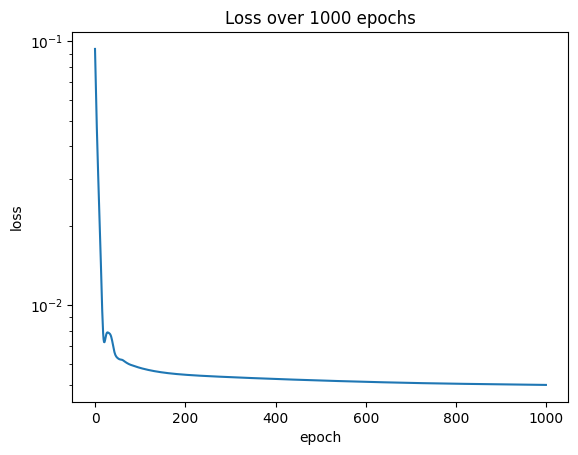

In [14]:
a_losses = losses
t_0 = 0
t_end = min(20000, n_iter)
t = np.arange(t_0, t_end)

plt.plot(t, a_losses[0, t_0:t_end])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.yscale("log")
plt.title(f"Loss over {n_iter} epochs")

In order to look at our flow we dont just need the output of the network we also require the some partial derivative ($v = -\psi_x$, $u = \psi_y$). Having this be part of the object oriented XPINNS network seems cumbersome. We can however extract the paramaters, and use our previous functions.

In [15]:
def uv(params, xy):
    v_negated, u = d_psi_dxy(params, xy)
    return np.array([u, -v_negated])

uv = jit(vmap(uv, (None, 0)))
p = jit(vmap(p, (None, 0)))
j_model = jit(v_model)

In [22]:
def pinn_predict(params, args: dict[str, Array]):
    b = args["boundary"]
    i = args["interior"]
    if b.size == 0:
        points = i
    else:
        points = np.vstack([b, i])

    net_output = j_model(params, points)
    preassure = net_output[:, 1]
    preassure = p(params, points)
    streamfunction = net_output[:, 0]
    flow = uv(params, points)
    flow_magnitude = np.sqrt(np.sum(flow**2, axis=1))

    return points, flow, flow_magnitude, preassure, streamfunction

In [23]:
import json
from pathlib import Path

def predict(input_file: str | Path = None):
    if input_file:
        main_args = {}
        with open(input_file) as infile:
            data = json.load(infile)

        for i, item in enumerate(data["XPINNs"]):
            interior = np.asarray(item["Internal points"])
            boundary = np.asarray(item["Boundary points"])

            main_args[i] = {"boundary": boundary, "interior": interior}

    else:
        main_args = xpinn.main_args

    total_streamfunction = []
    total_points = []
    total_flow = []
    total_p = []
    total_flow_magnitude = []


    for i, pinn in enumerate(xpinn.PINNs):
        params = pinn.params
        points, flow, flow_magnitude, p, streamfunction = pinn_predict(params, main_args[i])
        
        total_flow_magnitude.append(flow_magnitude)
        total_streamfunction.append(streamfunction)
        total_points.append(points)
        total_flow.append(flow)
        total_p.append(p)

    return total_points, total_flow, total_p, total_streamfunction

In [18]:
points, flow, preassure, streamfunction = predict(file_test)

tot_flow = np.concatenate(flow)
tot_preassure  =  np.concatenate(preassure)
tot_streamfunction = np.concatenate(streamfunction)



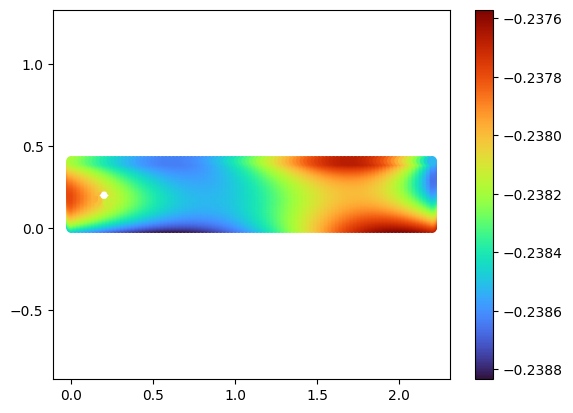

In [20]:
min_, max_ = tot_preassure.min(), tot_preassure.max()

for point, pred in zip(points, preassure):
    plt.scatter(point[:,0], point[:,1], c = pred, cmap="turbo", label="preassure")
plt.title("Preassure")
plt.clim(min_, max_)
plt.axis("equal")
plt.colorbar()

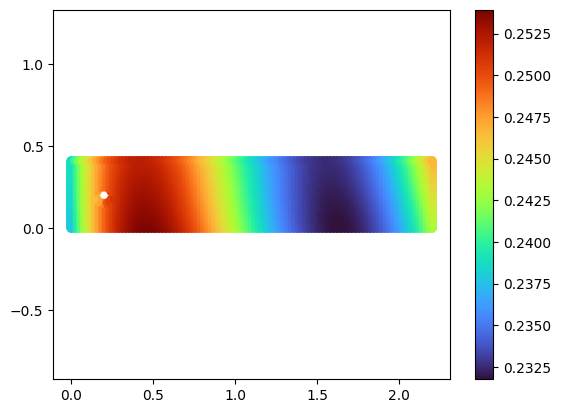

In [21]:
min_, max_ = tot_streamfunction.min(), tot_streamfunction.max()

for point, pred in zip(points, streamfunction):
    plt.scatter(point[:,0], point[:,1], c = pred, cmap="turbo", label="streamfunction")
plt.title("Streamfunction")
plt.clim(min_, max_)
plt.axis("equal")
plt.colorbar()
